<a href="https://colab.research.google.com/github/hasibulhshovo/COMP432/blob/main/lab6/lab_6_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Decision Trees**
#### This notebook is designed for students to learn Decision Trees through theory, implementation, and visualization.

## 1. Learning Objectives & Introduction

### Learning Objectives
By completing this lab, students will:
1. Understand how Decision Trees partition the input space into regions.
2. Learn about impurity measures (Gini Index and Entropy) and their mathematical formulations.
3. Implement a Decision Tree Classifier and Regressor from scratch.
4. Train and evaluate a predefined Decision Tree Classifier and Regressor model from Scikit-learn.
5. Visualize the tree structure, decision boundaries, and performance metrics.
6. Compare performance between scratch and Scikit-learn implementations.

## 2. Importing Libraries & Dataset

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,  mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

In [2]:
# Load a public dataset - Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Split dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 120, Testing samples: 30


## 3. Mathematical Formulations

### 3.1 Region Partitioning and Majority Voting
Each region Rm corresponds to a leaf node of the tree. The predicted output is the most common class in that region.

$$O_m = \text{majority}\{i | x_i \in R_m\} y_i$$

### 3.2 Impurity Measures
1. **Gini Index:**
$$Q_m = \sum_k p_{m,k}(1 - p_{m,k})$$

2. **Entropy:**
$$Q_m = -\sum_k p_{m,k} \log(p_{m,k})$$

3. **Prediction Error:**
$$Q_m = 1 - p_{m, O_m}$$

### 3.3 Information Gain
$$Gain(S, F) = H(S) - \sum_{v \in values(F)} \frac{|S_v|}{|S|} H(S_v)$$

## 4. Building Decision Tree Classifier from Scratch

In [3]:
# Function to calculate Gini impurity
def gini(y):
    classes = np.unique(y)  # Get unique class labels
    impurity = 1.0
    for c in classes:
        p = np.sum(y == c) / len(y)  # Probability of class c
        impurity -= p ** 2           # Subtract squared probability
    return impurity

# Function to calculate entropy
def entropy(y):
    classes = np.unique(y)  # Get unique class labels
    ent = 0.0
    for c in classes:
        p = np.sum(y == c) / len(y)  # Probability of class c
        ent -= p * np.log2(p + 1e-9)  # Entropy formula with small epsilon to avoid log(0)
    return ent

# Function to split the dataset into left and right branches based on feature threshold
def split_dataset(X, y, feature_index, threshold):
    left_mask = X[:, feature_index] < threshold   # Mask for left split
    right_mask = X[:, feature_index] >= threshold # Mask for right split
    return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

# Class representing a single node in the decision tree
class DecisionNode:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index  # Index of the feature to split on
        self.threshold = threshold          # Threshold value to split at
        self.left = left                    # Left child node
        self.right = right                  # Right child node
        self.value = value                  # Class prediction if it's a leaf node

# Class implementing the decision tree classifier from scratch
class DecisionTreeScratchClassifier:
    def __init__(self, max_depth=5, criterion='gini'):
        self.max_depth = max_depth                          # Maximum depth of the tree
        self.criterion = gini if criterion == 'gini' else entropy  # Split criterion
        self.root = None                                    # Root node of the tree

    # Recursive function to build the tree
    def fit(self, X, y, depth=0):
        # If all samples have the same class or max depth reached, create a leaf node
        if len(np.unique(y)) == 1 or depth >= self.max_depth:
            return DecisionNode(value=np.bincount(y).argmax())  # Majority class

        best_gain = 0
        best_criteria = None
        best_sets = None
        current_impurity = self.criterion(y)  # Calculate impurity before the split

        # Try all features and all thresholds to find the best split
        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])  # Unique values for the feature
            for threshold in thresholds:
                # Split the dataset
                X_left, y_left, X_right, y_right = split_dataset(X, y, feature_index, threshold)

                # Skip invalid splits
                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                # Calculate information gain
                p = len(y_left) / len(y)
                gain = current_impurity - (
                    p * self.criterion(y_left) + (1 - p) * self.criterion(y_right)
                )

                # Update the best split if gain is improved
                if gain > best_gain:
                    best_gain = gain
                    best_criteria = (feature_index, threshold)
                    best_sets = (X_left, y_left, X_right, y_right)

        # If no gain, return a leaf node
        if best_gain == 0:
            return DecisionNode(value=np.bincount(y).argmax())

        # Recursively build the left and right branches
        left = self.fit(best_sets[0], best_sets[1], depth + 1)
        right = self.fit(best_sets[2], best_sets[3], depth + 1)

        # Create a decision node with the best split
        self.root = DecisionNode(best_criteria[0], best_criteria[1], left, right)
        return self.root

    # Function to predict a single sample
    def predict_one(self, x, node):
        if node.value is not None:  # If it's a leaf node
            return node.value
        # Recursively traverse the left or right child based on the threshold
        if x[node.feature_index] < node.threshold:
            return self.predict_one(x, node.left)
        else:
            return self.predict_one(x, node.right)

    # Function to predict a batch of samples
    def predict(self, X):
        return np.array([self.predict_one(x, self.root) for x in X])

# Train Scratch Decision Tree using entropy as the criterion
tree_scratch = DecisionTreeScratchClassifier(max_depth=5, criterion='entropy')
tree_scratch.fit(X_train, y_train)

# Make predictions
y_pred_scratch = tree_scratch.predict(X_test)

# Evaluate model performance
print("Scratch Decision Tree Accuracy:", accuracy_score(y_test, y_pred_scratch))
print(classification_report(y_test, y_pred_scratch))

Scratch Decision Tree Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



## 5. Using Scikit-learn Decision Tree


Scikit-learn Decision Tree Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



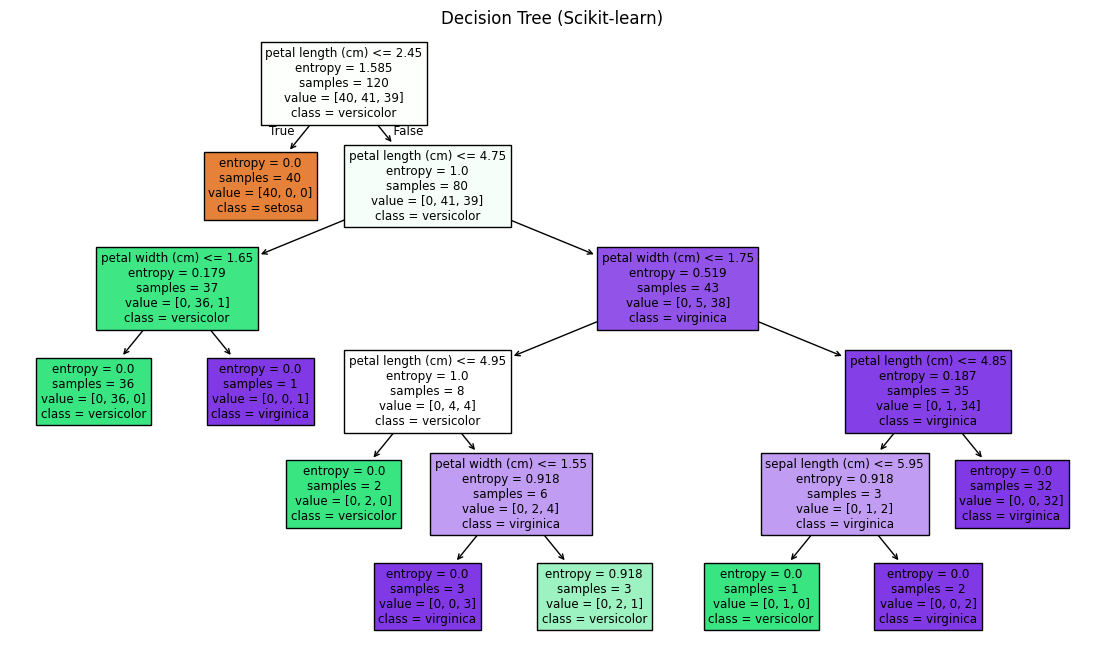

In [4]:
# Initialize the DecisionTreeClassifier with specific parameters:
# max_depth: Limit the depth of the tree to avoid overfitting
# criterion: Use 'entropy' to measure the quality of a split (information gain)
# random_state: Set for reproducibility of results
clf = DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=42)

# Train the decision tree classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lib = clf.predict(X_test)

# Evaluate the model's performance:
# Calculate accuracy on the test set
print("\nScikit-learn Decision Tree Accuracy:", accuracy_score(y_test, y_pred_lib))

# Display a detailed classification report showing precision, recall, f1-score, and support for each class
print(classification_report(y_test, y_pred_lib))

# Visualize the trained decision tree using plot_tree
# This function visualizes the decision tree and shows how it makes decisions based on the features
plt.figure(figsize=(14,8))  # Set the figure size for the plot
plot_tree(clf,
          feature_names=iris.feature_names,  # Pass feature names for better visualization
          class_names=iris.target_names,      # Pass class names to display in the plot
          filled=True)                        # Color the nodes based on their class
plt.title("Decision Tree (Scikit-learn)")  # Set the title for the plot
plt.show()  # Display the plot

## 6. Comparison and Visualization

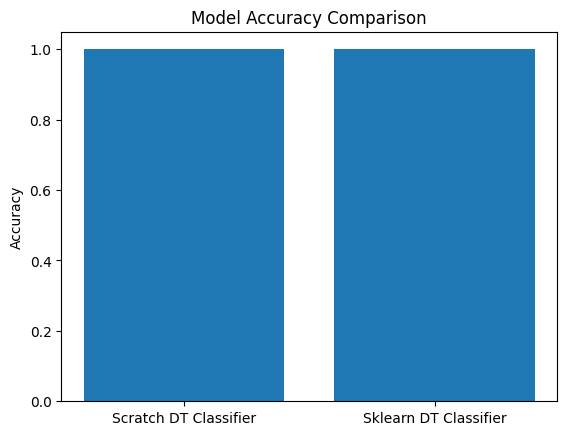

In [5]:
# Create a bar chart to compare the accuracy of the two models
# The x-axis represents the two models: Scratch Decision Tree and Sklearn Decision Tree
# The y-axis represents their respective accuracy scores on the test data

plt.bar(
    ['Scratch DT Classifier', 'Sklearn DT Classifier'],  # X-axis labels for the two models
    [accuracy_score(y_test, y_pred_scratch), accuracy_score(y_test, y_pred_lib)]  # Accuracy values for each model
)

# Set the title for the bar chart
plt.title('Model Accuracy Comparison')

# Label the y-axis to indicate that it represents accuracy scores
plt.ylabel('Accuracy')

# Display the chart
plt.show()

## 7. Decision Tree Regression (Scratch & Scikit-learn)

In [6]:
# Load the diabetes dataset from scikit-learn's built-in datasets
boston = datasets.load_diabetes()

# Extract the features (Xr) and target values (yr) from the dataset
Xr, yr = boston.data, boston.target

# Split the dataset into training and testing sets
# test_size=0.2 means 20% of the data is used for testing, 80% for training
# random_state=42 ensures reproducibility of the split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=42)

In [7]:
# Implementation of a Decision Tree Regressor from scratch
class DecisionTreeScratchRegressor:
    def __init__(self, max_depth=5, min_samples_split=5):
        self.max_depth = max_depth                  # Maximum depth the tree can grow
        self.min_samples_split = min_samples_split  # Minimum number of samples required to split
        self.root = None                            # Root node of the tree

    # Mean Squared Error (MSE) calculation for regression
    def mse(self, y):
        return np.mean((y - np.mean(y)) ** 2)  # Measures variance within the target values

    # Recursive method to build the regression tree
    def fit(self, X, y, depth=0):
        # Stop recursion if max depth is reached or not enough samples to split
        if depth >= self.max_depth or len(y) < self.min_samples_split:
            return DecisionNode(value=np.mean(y))  # Create a leaf node with mean of target values

        best_gain = 0
        best_criteria = None
        best_sets = None
        current_error = self.mse(y)  # Calculate MSE before the split (total error)

        # Iterate through all features
        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])  # Unique thresholds for the feature
            for threshold in thresholds:
                # Split dataset based on the feature and threshold
                X_left, y_left, X_right, y_right = split_dataset(X, y, feature_index, threshold)

                # Skip if either side of the split has no samples
                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                # Weighted average of MSE for the split
                p = len(y_left) / len(y)
                gain = current_error - (p * self.mse(y_left) + (1 - p) * self.mse(y_right))

                # Update best split if gain improves
                if gain > best_gain:
                    best_gain = gain
                    best_criteria = (feature_index, threshold)
                    best_sets = (X_left, y_left, X_right, y_right)

        # If no gain (no improvement), return a leaf node
        if best_gain == 0:
            return DecisionNode(value=np.mean(y))

        # Recursively build left and right subtrees
        left = self.fit(best_sets[0], best_sets[1], depth + 1)
        right = self.fit(best_sets[2], best_sets[3], depth + 1)

        # Return a decision node containing the best split criteria
        return DecisionNode(best_criteria[0], best_criteria[1], left, right)

    # Public method to initiate training
    def train(self, X, y):
        self.root = self.fit(X, y)  # Start recursive tree building from the root

    # Predict a single sample by traversing the tree
    def predict_one(self, x, node):
        if node.value is not None:
            return node.value  # Return prediction at leaf node
        if x[node.feature_index] <= node.threshold:
            return self.predict_one(x, node.left)  # Traverse left branch
        else:
            return self.predict_one(x, node.right)  # Traverse right branch

    # Predict multiple samples by calling predict_one for each sample in X
    def predict(self, X):
        return np.array([self.predict_one(x, self.root) for x in X])

In [8]:
# Instantiate and train the scratch-built decision tree regressor
# Using max_depth=6 to limit tree depth and min_samples_split=10 to avoid overfitting
reg_scratch = DecisionTreeScratchRegressor(max_depth=6, min_samples_split=10)
reg_scratch.train(Xr_train, yr_train)  # Train the model on the training set
yr_pred_scratch = reg_scratch.predict(Xr_test)  # Predict target values on the test set

# Instantiate and train the scikit-learn DecisionTreeRegressor with the same parameters
reg_lib = DecisionTreeRegressor(max_depth=6, min_samples_split=10, random_state=42)
reg_lib.fit(Xr_train, yr_train)  # Train the scikit-learn model
yr_pred_lib = reg_lib.predict(Xr_test)  # Predict using the trained model

# Calculate Mean Squared Error (MSE) for both models to evaluate how far off predictions are on average
mse_scratch = mean_squared_error(yr_test, yr_pred_scratch)  # MSE for scratch model
mse_lib = mean_squared_error(yr_test, yr_pred_lib)          # MSE for scikit-learn model

# Calculate R² Score (Coefficient of Determination) for both models
# Measures how well the predictions approximate the true values (1.0 = perfect fit)
acc_scratch = r2_score(yr_test, yr_pred_scratch)  # R² score for scratch model
acc_lib = r2_score(yr_test, yr_pred_lib)          # R² score for scikit-learn model

# Print evaluation metrics for both models
print("Scratch Regressor MSE:", mse_scratch)
print("Scratch Regressor R² Score (Accuracy):", acc_scratch)
print("Scikit-learn Regressor MSE:", mse_lib)
print("Scikit-learn Regressor R² Score (Accuracy):", acc_lib)

Scratch Regressor MSE: 3968.5860416779656
Scratch Regressor R² Score (Accuracy): 0.2509489667242719
Scikit-learn Regressor MSE: 3711.8923318022216
Scikit-learn Regressor R² Score (Accuracy): 0.2993986378662158


Text(0, 0.5, 'Mean Squared Error')

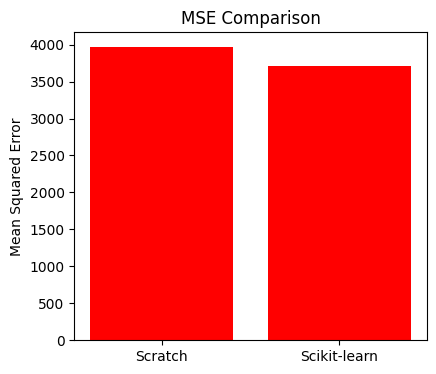

In [9]:
# Plotting Mean Squared Error (MSE) for both regressors as a bar chart
plt.figure(figsize=(10, 4))  # Set the overall figure size (width=10, height=4 inches)

# Create the first subplot (1 row, 2 columns, this is the 1st plot)
plt.subplot(1, 2, 1)

# Plot a bar chart comparing MSE for the Scratch and Scikit-learn regressors
plt.bar(
    ['Scratch', 'Scikit-learn'],        # X-axis labels for each model
    [mse_scratch, mse_lib],             # Y-axis values (MSE scores)
    color='red'                         # Color of the bars
)

# Set the title of the chart
plt.title('MSE Comparison')

# Label the Y-axis to indicate what is being measured
plt.ylabel('Mean Squared Error')

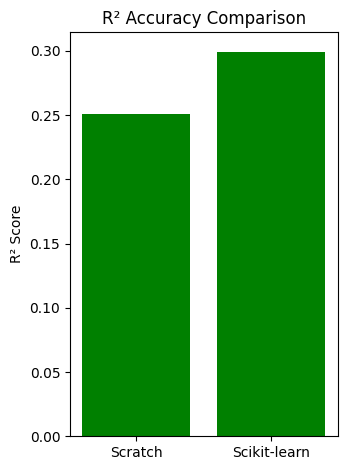

In [10]:
# R² Accuracy Bar Chart (Second subplot in the same figure)
plt.subplot(1, 2, 2)  # Create the second subplot (1 row, 2 columns, this is the 2nd plot)

# Plot a bar chart comparing R² scores for the Scratch and Scikit-learn regressors
plt.bar(
    ['Scratch', 'Scikit-learn'],       # X-axis labels for each model
    [acc_scratch, acc_lib],            # Y-axis values (R² scores)
    color='green'                      # Color of the bars
)

# Set the title for the second subplot
plt.title('R² Accuracy Comparison')

# Label the Y-axis to indicate the metric being shown
plt.ylabel('R² Score')

# Adjust layout so subplots don't overlap or get clipped
plt.tight_layout()

# Display the combined figure with both MSE and R² bar charts
plt.show()


---
# Task Sequence

Below are 4 tasks and each builds on outputs from the previous task. Complete them in order.

- **Task 1** prepares the dataset and EDA.
- **Task 2** implements a simple Decision Tree classifier from scratch using that split.
- **Task 3** trains a sklearn DecisionTree on the same split and compares/visualizes the results.
- **Task 4** moves to regression (scratch + sklearn) using the Diabetes dataset and compares metrics.
---



## Task 1 — Dataset & EDA (base for all subsequent tasks)

**Objective:** Load the Breast Cancer Wisconsin dataset from sklearn and save an **80-20 train/test split** that will be reused by Tasks 2 and 3.

**Deliverables:** A cleaned `X_train, X_test, y_train, y_test` and EDA plots (class distribution and 2D scatter for two chosen features).

**Hint:** `datasets.load_breast_cancer()` to load the dataset. Then, use `train_test_split(..., stratify=y, test_size=0.2, random_state=42)` to split the data into an 80-20 train-test split, ensuring that the class distribution is preserved in both sets.


In [ ]:
cancer = datasets.load_breast_cancer(as_frame=True)
df = cancer.frame.copy()  # dataframe with features and target
# Write the code below


## Task 2 — Decision Tree Classifier (From Scratch)

**Objective:** Implement a simple Decision Tree classifier (binary splits) using the training data produced in Task 1. Keep `max_depth=3` initially for interpretability.

**Key steps (suggested):**
1. Implement `gini(y)` function.
2. Implement `split_dataset(X, y, feature_index, threshold)`.
3. Implement greedy `fit` that finds best split by maximizing information gain (using reduction in impurity).
4. Implement `predict` by traversing the tree.
5. Evaluate `accuracy` on the test set (from Task 1).

**Hint:** Use unique values of each feature for thresholds; return majority class at leaves.


In [ ]:
# Function to compute Gini impurity for a list of class labels
def gini(y):
    classes = np.unique(y)  # Get the unique classes in the labels
    impurity = 1.0          # Start with maximum impurity
    for c in classes:
        p = np.sum(y == c) / len(y)  # Proportion of class c
        impurity -= p**2             # Subtract the squared probability from impurity
    return impurity  # Lower values indicate purer splits

# Function to split the dataset based on a given feature and threshold
def split_dataset(X, y, feature_index, threshold):
    # Create a boolean mask for samples that go to the left node (feature value < threshold)
    left_mask = X[:, feature_index] < threshold
    # Return the split features and labels: left and right branches
    return X[left_mask], y[left_mask], X[~left_mask], y[~left_mask]

# Node class represents a single node in the decision tree
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index  # Index of the feature used for the split
        self.threshold = threshold          # Threshold value for the split
        self.left = left                    # Left child node
        self.right = right                  # Right child node
        self.value = value                  # Predicted class (for leaf nodes)

# Scratch implementation of a simple Decision Tree Classifier
class ScratchTree:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth  # Maximum depth to grow the tree
        self.root = None            # Root node of the tree

    def fit(self, X, y):
        # This method should implement recursive tree building using:
        # - Gini impurity to find the best split
        # - Majority class as the predicted value for leaf nodes
        raise NotImplementedError('Please implement fit() for ScratchTree')

    def predict_one(self, x, node):
        # This method should recursively traverse the tree starting from the root node
        # and return the predicted class for a single input sample
        raise NotImplementedError('Please implement predict_one()')

    def predict(self, X):
        # Predict the class for each sample in the input matrix X
        # Calls predict_one for each sample and returns the results as a numpy array
        return np.array([self.predict_one(x, self.root) for x in X])

# After implementing, train and evaluate:
# scratch_tree = ScratchTree(max_depth=3);
# scratch_tree.fit(X_train, y_train)
# y_pred_scratch = scratch_tree.predict(X_test)
# print('Scratch accuracy: ...')



## Task 3 — Scikit-learn DecisionTree + Comparison

**Objective:** Train `DecisionTreeClassifier` from scikit-learn on the same split. Compare **accuracy**, **confusion matrix**, and **visualize** both the sklearn tree and decision boundaries for the first two features. Discuss where and why the two implementations (scratch vs sklearn) differ.

**Hint:** Use `plot_tree` to visualize and the decision-boundary helper provided below to plot for 2D.


In [ ]:
# Function to plot decision boundaries using two features of the dataset
def plot_decision_boundary(model, X, y, features=(0,1), title='Decision boundary'):
    # Define the min and max values for the two features with padding for visualization
    x_min, x_max = X[:, features[0]].min() - 0.5, X[:, features[0]].max() + 0.5
    y_min, y_max = X[:, features[1]].min() - 0.5, X[:, features[1]].max() + 0.5

    # Create a mesh grid covering the feature space
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

    # Flatten the grid points and prepare them for prediction
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Create a full feature set by replicating the mean of all features (to keep other features constant)
    full_grid = np.tile(np.mean(X, axis=0), (grid.shape[0], 1))

    # Replace the two selected features with the grid values
    full_grid[:, features[0]] = grid[:, 0]
    full_grid[:, features[1]] = grid[:, 1]

    # Predict class labels for each point in the grid
    preds = model.predict(full_grid).reshape(xx.shape)

    # Plot the decision boundary using a contour plot
    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, preds, alpha=0.3)  # Colored regions based on prediction

    # Scatter plot of the original data points, colored by true class
    plt.scatter(X[:, features[0]], X[:, features[1]], c=y, edgecolor='k')

    # Label axes with feature names
    plt.xlabel(cancer.feature_names[features[0]])
    plt.ylabel(cancer.feature_names[features[1]])

    # Set plot title
    plt.title(title)
    plt.show()

# Write the code below


# ---------------------------------------------------------------------------------------
plot_decision_boundary(clf, X_train, y_train, (0,1), 'Sklearn Decision Boundary (Train)')
plot_decision_boundary(clf, X_test, y_test, (0,1), 'Sklearn Decision Boundary (Test)')



## Task 4 — Decision Tree Regression chain (connected to above)

**Objective:** Using the California Housing dataset (`datasets.fetch_california_housing()` to load the dataset), implement a simple Decision Tree Regressor (scratch) and compare with `DecisionTreeRegressor` from sklearn. Use an 80-20 train/test split and report **MSE** and **R²**. Visualize predictions (scatter plot y_true vs y_pred) and residuals.

**Hint:** Use MSE as impurity. Nodes should predict the mean target of their region.


In [ ]:
# load the dataset and split it for train and test (in 3 lines)




# ---------------------------------------------------------------------------------------------

# Suggestion: Implement SimpleRegressor similar to the classifier but using MSE to choose splits (Complete the Regressor model code, follow the examples above)
class SimpleRegressor:
def __init__(self, max_depth=4, min_samples_split=4):
        # Maximum depth of the decision tree
        self.max_depth = max_depth
        # Minimum number of samples required to split an internal node
        self.min_samples_split = min_samples_split
        # Root node of the decision tree (will be set after training)
        self.root = None

    def mse(self, y):
        # Calculate Mean Squared Error (MSE) of target values y
        # MSE is the average squared difference between each value and the mean of y
        return np.mean((y - np.mean(y)) ** 2)

    def fit(self, X, y):
        # Method to train the decision tree regressor
        # Not implemented here; expected to build the tree and assign it to self.root
        raise NotImplementedError('Implement fit for SimpleRegressor')

    def predict_one(self, x, node):
        # Predict the target value for a single input sample x starting from a given node
        # This should recursively traverse the tree until a leaf node is reached
        raise NotImplementedError('Implement traversal/predict for SimpleRegressor')

    def predict(self, X):
        # Predict target values for all samples in dataset X
        # Calls predict_one on each sample starting from the root node
        return np.array([self.predict_one(x, self.root) for x in X])

# After implementing: compare with sklearn and complete the rest of the task
# reg_scratch = SimpleRegressor(max_depth=4);
# reg_scratch.fit(Xr_train, yr_train)
# pred_scratch = reg_scratch.predict(Xr_test)
# print('Scratch MSE:', mean_squared_error(yr_test, pred_scratch))
# Use sklearn DecisionTreeRegressor for comparison:
# reg_lib = DecisionTreeRegressor(max_depth=4, random_state=42);
# reg_lib.fit(Xr_train, yr_train)
# pred_lib = reg_lib.predict(Xr_test); print('Sklearn MSE:', mean_squared_error(yr_test, pred_lib))
